In [4]:
# Instalación de cuDF, cuML, cuGraph y demás usando pip
!pip install cudf-cu12 cuml-cu12 cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.6
    Uninstalling Jinja2-3.1.6:
      Successfully uninstalled Jinja2-3.1.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-

In [3]:
#prueba para comprobar nombres de las listas
import os
import pyvis

print(os.listdir(os.path.join(pyvis.__path__[0], "templates")))

['animation_template.html', 'lib', 'template.html']


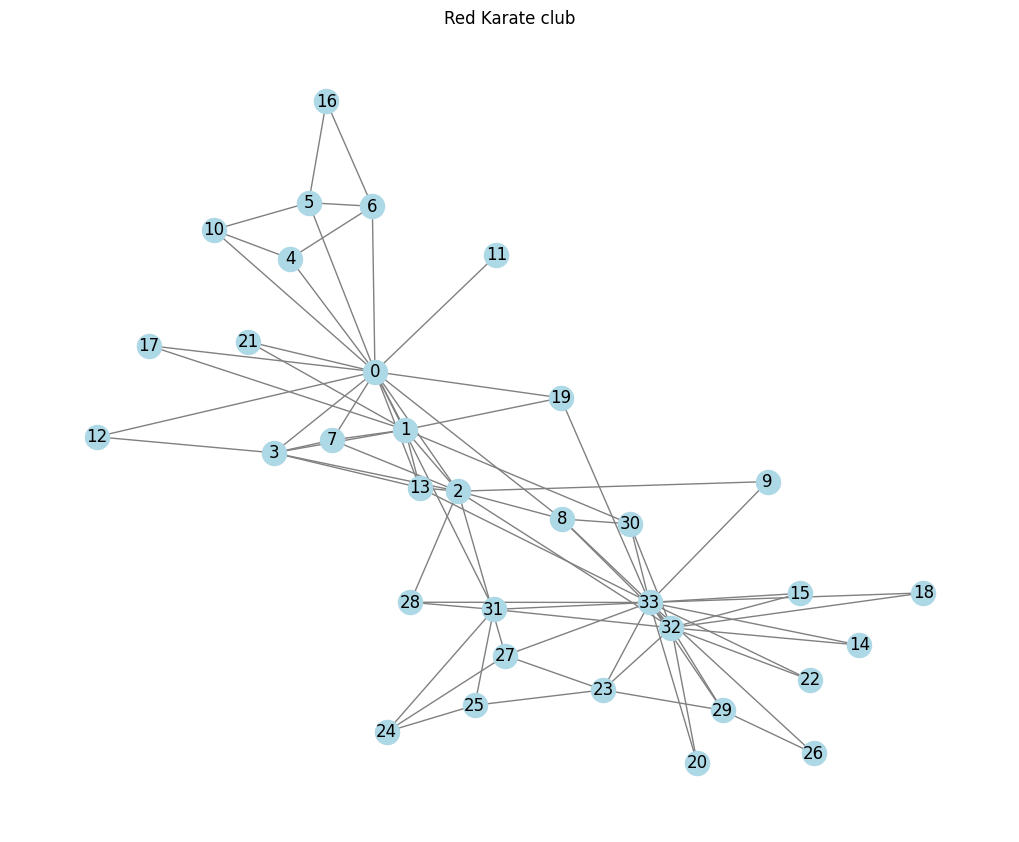

red_karate_club.html


In [10]:
import cugraph
import cudf
import matplotlib.pyplot as plt
from pyvis.network import Network
import networkx as nx

# Cargar el grafo desde NetworkX
G_nx = nx.karate_club_graph()

# Dibujar
plt.figure(figsize=(10, 8))
nx.draw(G_nx, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Red Karate club")
plt.show()

# INTERACTIVO
###########
# Calcular el grado de cada nodo
grado = dict(G_nx.degree())
max_grado = max(grado.values())

# Crear visualización
net = Network(height="750px", width="100%", notebook=True, bgcolor="#222", font_color="white")

# Agregar nodos con colores según grado
for node in G_nx.nodes():
    g = grado[node]
    color = f"rgb({255 - int(255 * g / max_grado)}, {int(255 * g / max_grado)}, 100)"  # de rojo a verde
    size = 15 + 20 * g / max_grado
    net.add_node(node, label=str(node), color=color, size=size)

# Agregar aristas
for source, target in G_nx.edges():
    net.add_edge(source, target)

# Mostrar
net.show("red_karate_club.html")

# Convertir a cuGraph (de NetworkX a cudf dataframe)
edges = nx.to_pandas_edgelist(G_nx)
edges_cudf = cudf.DataFrame.from_pandas(edges[['source', 'target']])

# Crear grafo cuGraph
G_cu = cugraph.Graph()
G_cu.from_cudf_edgelist(edges_cudf, source='source', destination='target')

In [ ]:
#PAGERANK
#nodos influyentes
pagerank_df = cugraph.pagerank(G_cu)
print(pagerank_df.sort_values(by='pagerank', ascending=False))
#out: indice, ID nodo, PageRank (la suma de todos da 1)

    vertex  pagerank
0       33  0.100917
1        0  0.096999
2       32  0.071692
3        2  0.057078
4        1  0.052877
6       31  0.037158
5        3  0.035860
9       23  0.031522
7        8  0.029766
8       13  0.029537
10       5  0.029112
11       6  0.029112
14      29  0.026288
13      27  0.025639
15      30  0.024590
12       7  0.024491
16       4  0.021979
17      10  0.021979
19      24  0.021076
20      25  0.021006
18      19  0.019605
21      28  0.019573
26      16  0.016785
32      26  0.015044
23      12  0.014645
27      17  0.014559
30      21  0.014559
24      14  0.014536
25      15  0.014536
28      18  0.014536
29      20  0.014536
31      22  0.014536
22       9  0.014309
33      11  0.009565


/usr/local/lib/python3.11/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


In [13]:
#DEGREE CENTRALITY
# Numero de conexiones de cada nodo (Grado)
centralidad = nx.degree_centrality(G_nx)
# show
for nodo, valor in centralidad.items():
    print(f"vertex {nodo}: centralidad = {valor:.4f}")
#out: nodo, distribucion de centralidad

vertex 0: centralidad = 0.4848
vertex 1: centralidad = 0.2727
vertex 2: centralidad = 0.3030
vertex 3: centralidad = 0.1818
vertex 4: centralidad = 0.0909
vertex 5: centralidad = 0.1212
vertex 6: centralidad = 0.1212
vertex 7: centralidad = 0.1212
vertex 8: centralidad = 0.1515
vertex 9: centralidad = 0.0606
vertex 10: centralidad = 0.0909
vertex 11: centralidad = 0.0303
vertex 12: centralidad = 0.0606
vertex 13: centralidad = 0.1515
vertex 14: centralidad = 0.0606
vertex 15: centralidad = 0.0606
vertex 16: centralidad = 0.0606
vertex 17: centralidad = 0.0606
vertex 18: centralidad = 0.0606
vertex 19: centralidad = 0.0909
vertex 20: centralidad = 0.0606
vertex 21: centralidad = 0.0606
vertex 22: centralidad = 0.0606
vertex 23: centralidad = 0.1515
vertex 24: centralidad = 0.0909
vertex 25: centralidad = 0.0909
vertex 26: centralidad = 0.0606
vertex 27: centralidad = 0.1212
vertex 28: centralidad = 0.0909
vertex 29: centralidad = 0.1212
vertex 30: centralidad = 0.1212
vertex 31: central

In [ ]:
#LOUVAIN
#encontrar grupos de nodos mas conectados entre si (comunidades)
#separacion de los grupos de karate
parts, _ = cugraph.louvain(G_cu)
print(parts)
#out: indice, ID nodo, comunidad asignada

    vertex  partition
0       33          1
1        0          0
2       32          1
3        2          0
4        1          0
5        3          0
6       31          2
7        8          1
8       13          0
9       23          1
10       5          3
11       6          3
12       7          0
13      27          1
14      29          1
15      30          1
16       4          3
17      10          3
18      19          0
19      24          2
20      25          2
21      28          2
22       9          0
23      12          0
24      14          1
25      15          1
26      16          3
27      17          0
28      18          1
29      20          1
30      21          0
31      22          1
32      26          1
33      11          0


In [22]:
#TRIANGLE COUNTING
#Si A-B, B-C y C-A existen, entonces {A, B, C} forma un triángulo
triangulos = nx.triangles(G_nx)  # Diccionario: nodo -> # de triángulos que contiene
total_triangulos = sum(triangulos.values()) // 3  # Cada triángulo se cuenta 3 veces

print(f"Total de triángulos en el grafo: {total_triangulos}")

#CLUSTERING COEFFICIENT
cc_local = nx.clustering(G_nx)

for nodo, cc in cc_local.items():
    print(f"{nodo}: C = {cc:.3f}")
#out: nodo, C = probabilidad de que los vecinos esten conectados/ para vallidar triangulos

Total de triángulos en el grafo: 45
0: C = 0.150
1: C = 0.333
2: C = 0.244
3: C = 0.667
4: C = 0.667
5: C = 0.500
6: C = 0.500
7: C = 1.000
8: C = 0.500
9: C = 0.000
10: C = 0.667
11: C = 0.000
12: C = 1.000
13: C = 0.600
14: C = 1.000
15: C = 1.000
16: C = 1.000
17: C = 1.000
18: C = 1.000
19: C = 0.333
20: C = 1.000
21: C = 1.000
22: C = 1.000
23: C = 0.400
24: C = 0.333
25: C = 0.333
26: C = 1.000
27: C = 0.167
28: C = 0.333
29: C = 0.667
30: C = 0.500
31: C = 0.200
32: C = 0.197
33: C = 0.110


In [21]:
#BETWEENNESS CENTRALITY
betweenness = nx.betweenness_centrality(G_nx, normalized=True)

for nodo, valor in sorted(betweenness.items(), key=lambda x: x[1], reverse=True):
    print(f"{nodo}: C_B = {valor:.4f}")
#out: nodo, que tan importante es un nodo para conectar a otros (suma 1)

0: C_B = 0.4376
33: C_B = 0.3041
32: C_B = 0.1452
2: C_B = 0.1437
31: C_B = 0.1383
8: C_B = 0.0559
1: C_B = 0.0539
13: C_B = 0.0459
19: C_B = 0.0325
5: C_B = 0.0300
6: C_B = 0.0300
27: C_B = 0.0223
23: C_B = 0.0176
30: C_B = 0.0144
3: C_B = 0.0119
25: C_B = 0.0038
29: C_B = 0.0029
24: C_B = 0.0022
28: C_B = 0.0018
9: C_B = 0.0008
4: C_B = 0.0006
10: C_B = 0.0006
7: C_B = 0.0000
11: C_B = 0.0000
12: C_B = 0.0000
14: C_B = 0.0000
15: C_B = 0.0000
16: C_B = 0.0000
17: C_B = 0.0000
18: C_B = 0.0000
20: C_B = 0.0000
21: C_B = 0.0000
22: C_B = 0.0000
26: C_B = 0.0000
